# Uwezo — Bank Statement Layout Detection

This notebook builds and evaluates a **layout detector** for bank statements as part of Uwezo’s document-verification pipeline. It covers:

- **Data loading & conversion (CreateML → YOLO, “You Only Look Once”)**  
  Convert Apple’s **CreateML** annotation format into **YOLO** format (images + text labels + `dataset.yaml`).

- **Exploratory Data Analysis (EDA)**  
  Inspect class balance, visualize labeled samples, and look for labeling gaps.

- **Training & validation with YOLOv8**  
  Train a modern object detector (**YOLOv8**) to find tables and key text regions; evaluate with standard metrics.

- **Quick inference and model export (ONNX, “Open Neural Network eXchange”)**  
  Run predictions on sample pages and export the trained model to **ONNX** for easy deployment.

- **Pointers for downstream OCR (“Optical Character Recognition”) + IE (“Information Extraction”) with LayoutLMv3**  
  After detection, run **OCR** to read text and use **LayoutLMv3** (a layout-aware transformer model) to extract fields like account holder name, bank name, opening balance, total credit, total debit, and closing balance. Apply rule checks such as  
  `opening balance + total credit − total debit ≈ closing balance`.

---
## Why this matters (KYC context)
Bank statements help verify:
- **Identity & ownership** (name, bank, account number),
- **Financial behavior** (credits/debits),
- **Consistency** (opening + credits − debits ≈ closing).

Automating layout detection reduces manual workload and feeds a **human-in-the-loop** review loop for continuous improvement.


## Mini-glossary
- **YOLO (You Only Look Once):** A family of fast object-detection models (we use **YOLOv8**).  
- **CreateML:** Apple’s dataset/annotation format often used by Xcode/Apple tooling.  
- **EDA (Exploratory Data Analysis):** Quick checks and visualizations to understand your dataset.  
- **OCR (Optical Character Recognition):** Converting images of text into machine-readable text.  
- **IE (Information Extraction):** Pulling structured fields from text (e.g., totals, names, dates).  
- **LayoutLMv3:** A transformer model that uses text + layout (positions of words) for document understanding.  
- **ONNX (Open Neural Network eXchange):** A portable model format for inference across runtimes.  

---



## Imports

In [1]:
# Standard & paths
from pathlib import Path
import os, sys, json, shutil, random, re
from typing import List, Dict, Tuple
from collections import Counter, defaultdict
import warnings

# Data & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate

# CV / DL
import torch
from ultralytics import YOLO
import cv2
from PIL import Image
from datasets import Dataset, DatasetDict
from transformers import (
    LayoutLMv3Processor,
    LayoutLMv3ForTokenClassification,
    TrainingArguments,
    Trainer,
)

# Notebook utils
from tqdm import tqdm
from IPython.display import display, Image as IPyImage

#  Settings (warnings, seeds)
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#  Project paths 
NB_DIR = Path.cwd()

# Find project root
if NB_DIR.name == "notebooks" and (NB_DIR.parent / "yolo").exists():
    PROJECT_ROOT = NB_DIR.parent
elif (NB_DIR / "yolo").exists():
    PROJECT_ROOT = NB_DIR
else:
    PROJECT_ROOT = next((p for p in [NB_DIR, *NB_DIR.parents] if p.name == "uwezo_project"), NB_DIR.parent)

# Core folders
YOLO_ROOT   = (PROJECT_ROOT / "yolo").resolve()
RAW_IMG_DIR = YOLO_ROOT / "images"
RAW_LBL_DIR = YOLO_ROOT / "labels"

# Processed outputs
PROC_ROOT = (PROJECT_ROOT / "processed").resolve()
PROC_IMG  = PROC_ROOT / "images"
PROC_OCR  = PROC_ROOT / "ocr"
PROC_HF   = PROC_ROOT / "hf"

# Ensure subfolders exist
for p in [
    RAW_IMG_DIR / "train", RAW_IMG_DIR / "val",
    RAW_LBL_DIR / "train", RAW_LBL_DIR / "val",
    PROC_IMG / "train", PROC_IMG / "val",
    PROC_OCR / "train", PROC_OCR / "val",
    PROC_HF,
]:
    p.mkdir(parents=True, exist_ok=True)



## Create Test Split and visaulize a few samples

In [2]:
TEST_FRACTION = 0.15
USE_SYMLINKS  = False
IMG_EXTS      = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
SEED          = 42

CML_IN  = PROJECT_ROOT / "data" / "bank_statements.v1i.createml"
CML_OUT = PROJECT_ROOT / "data" / "bank_statements.split.createml"

train_json = CML_IN / "train" / "_annotations.createml.json"
valid_json = (CML_IN / "valid" / "_annotations.createml.json"
              if (CML_IN / "valid" / "_annotations.createml.json").exists()
              else CML_IN / "val" / "_annotations.createml.json")

def load_items(json_path: Path) -> list:
    with open(json_path, "r") as f:
        data = json.load(f)
    return data.get("images", []) if isinstance(data, dict) else (data if isinstance(data, list) else [])

def save_items(items: list, out_json: Path):
    out_json.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json, "w") as f:
        json.dump(items, f, indent=2)

def abs_image(json_file: Path, item: dict) -> Path:
    rel = item.get("image") or item.get("path") or item.get("file") or item.get("filename")
    return (json_file.parent / rel).resolve()

def copy_or_link(src: Path, dst: Path):
    if dst.exists(): return
    dst.parent.mkdir(parents=True, exist_ok=True)
    if USE_SYMLINKS:
        try: os.symlink(src, dst)
        except FileExistsError: pass
    else:
        shutil.copy2(src, dst)

# Load the train and validation dataset
if not train_json.exists():
    raise FileNotFoundError(f"Missing train annotations: {train_json}")

train_items_raw = load_items(train_json)
valid_items_raw = load_items(valid_json) if valid_json.exists() else []

# Enrich train with absolute path + stem, filter missing files
train_items = []
for it in train_items_raw:
    p = abs_image(train_json, it)
    if p.exists() and p.suffix.lower() in IMG_EXTS:
        it2 = dict(it)
        it2["_abs"] = str(p)
        it2["_stem"] = p.stem
        train_items.append(it2)

# Sample test from train
rng = random.Random(SEED)
n_cand = len(train_items)
n_test = max(1, int(n_cand * TEST_FRACTION)) if n_cand > 0 else 0

if n_test == 0:
    print("No candidates available in train; skipping test creation.")
    test_items = []
    new_train  = train_items
else:
    chosen = rng.sample(train_items, k=n_test)
    chosen_stems = {x["_stem"] for x in chosen}
    test_items = sorted(chosen, key=lambda x: x["_stem"])
    new_train  = [x for x in train_items if x["_stem"] not in chosen_stems]

print(f"Split from train → test: pool={n_cand}, test={len(test_items)}, train_remain={len(new_train)}")

# Write a new createML dataset
def write_split(split_name: str, items_enriched: list, out_root: Path, ref_json_dir: Path):
    out_dir = out_root / split_name
    out_dir.mkdir(parents=True, exist_ok=True)

    out_items = []
    for it in items_enriched:
        src = Path(it["_abs"])
        dst = out_dir / src.name
        copy_or_link(src, dst)
        out_items.append({
            "image": src.name,                    # relative to split folder
            "annotations": it.get("annotations", []),
            "width": it.get("width"),
            "height": it.get("height"),
        })
    save_items(out_items, out_dir / "_annotations.createml.json")
    return len(out_items)

# train (remaining) & test (sampled from train)
n_tr = write_split("train", new_train, CML_OUT, train_json)
n_te = write_split("test",  test_items, CML_OUT, train_json)

# If a valid split exists, copy it as-is (no sampling)
n_va = 0
if valid_items_raw:
    valid_dir = CML_OUT / "valid"
    valid_dir.mkdir(parents=True, exist_ok=True)
    out_items = []
    for it in valid_items_raw:
        p = abs_image(valid_json, it)
        if p.exists() and p.suffix.lower() in IMG_EXTS:
            copy_or_link(p, valid_dir / p.name)
            out_items.append({
                "image": p.name,
                "annotations": it.get("annotations", []),
                "width": it.get("width"),
                "height": it.get("height"),
            })
    save_items(out_items, valid_dir / "_annotations.createml.json")
    n_va = len(out_items)

print(f"Done → {CML_OUT}")
print(f"Counts: train={n_tr}  valid={n_va}  test={n_te}")


Split from train → test: pool=380, test=57, train_remain=323
Done → /Volumes/Peach/uwezo_capstone_project/uwezo_project/data/bank_statements.split.createml
Counts: train=323  valid=47  test=57


## 3) Convert CreateML → YOLO
The dataset we’re using is available in CreateML format, but our Uwezo bank-statement model is trained with a YOLOv8 detector to find layout elements such as tables, headers, account numbers, and statement periods. Converting the dataset lets us reuse the existing CreateML annotations without re-labeling and makes them compatible with YOLO’s training pipeline.

CreateML stores annotations in split-level JSON files with pixel coordinates (x, y, width, height), which works well for Apple’s CoreML but isn’t directly usable by the Ultralytics Python library we use for YOLO. YOLO, in contrast, expects:

one .txt label file per image with normalized (0–1) center-based coordinates <class_id> <cx> <cy> <w> <h>,

a specific folder layout: images/{train,val} and labels/{train,val},

and a dataset.yaml describing paths and class names.

After conversion, we train YOLO with dataset.yaml. The resulting detections then feed into OCR and LayoutLM to extract the actual financial fields.



In [3]:
# Classes to keep
MUST_KEEP = [
    "table_transactions_data",
    "table_transactions_header",
    "account_holder_name",
    "bank_name",
    "account_number",
    "statement_period",
]
INCLUDE_OPTIONAL = True
OPTIONAL = ["opening_balance", "currency", "doc_type"] if INCLUDE_OPTIONAL else []

CLASSES = MUST_KEEP + OPTIONAL
cls2id = {c: i for i, c in enumerate(CLASSES)}
print("Keeping classes:", CLASSES)

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

DATASET_ROOT = CML_OUT if (CML_OUT / "train").exists() else CML_IN

# Resolve split directories & their annotation files
def split_dir(name: str) -> Path:
    # 'valid' might be stored as 'valid' or 'val' on disk, but YOLO expects 'val'
    if name == "val":
        return (DATASET_ROOT / "valid") if (DATASET_ROOT / "valid").exists() else (DATASET_ROOT / "val")
    return DATASET_ROOT / name

def createml_json_for(split_name: str) -> Path:
    return split_dir(split_name) / "_annotations.createml.json"

# Collect only the splits that exist
CREATEML_JSONS = {}
for split in ["train", "val", "test"]:
    d = split_dir(split)
    j = createml_json_for(split)
    if d.exists() and j.exists():
        CREATEML_JSONS[split] = j

if "train" not in CREATEML_JSONS:
    raise FileNotFoundError("CreateML 'train' split not found under "
                            f"{DATASET_ROOT}. Expected a _annotations.createml.json in train/")

# Creat YOLO output folders
for split in CREATEML_JSONS.keys():
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

# Helpers
def clamp(v, lo, hi): 
    return max(lo, min(hi, v))

def to_center_norm(cx, cy, w, h, W, H):
    return cx / W, cy / H, w / W, h / H

def to_tl_norm(x, y, w, h, W, H):
    # convert TL pixel box to center-normalized
    return to_center_norm(x + w / 2, y + h / 2, w, h, W, H)

def write_label(label_path: Path, cls_id: int, box):
    cx, cy, w, h = box
    if not (0 < w <= 1 and 0 < h <= 1):
        return
    cx, cy = clamp(cx, 0, 1), clamp(cy, 0, 1)
    label_path.parent.mkdir(parents=True, exist_ok=True)
    with open(label_path, "a") as f:
        f.write(f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

def load_createml_items(json_path: Path):
    data = json.loads(json_path.read_text())
    return data.get("images", data) if isinstance(data, dict) else data

def find_image(cm_split_dir: Path, filename: str) -> Path | None:
    # First try split root (materialized case). Else fallback to searching within the split dir.
    direct = cm_split_dir / filename
    if direct.exists():
        return direct
    hits = list(cm_split_dir.rglob(filename))
    return hits[0] if hits else None

# Convert
converted, skipped, missing = Counter(), Counter(), []

for yolo_split, json_path in CREATEML_JSONS.items():
    cm_split_dir = json_path.parent
    items = load_createml_items(json_path)

    for row in items:
        fname = row.get("image") or row.get("file") or row.get("path") or row.get("filename")
        if not fname:
            skipped["no_filename"] += 1
            continue

        src = find_image(cm_split_dir, fname)
        if not src:
            missing.append((yolo_split, fname))
            continue

        # Image size for normalization
        try:
            with Image.open(src) as im:
                W, H = im.size
        except Exception:
            skipped["bad_image"] += 1
            continue

        # Prepare destinations
        dst_img = YOLO_ROOT / "images" / yolo_split / Path(fname).name
        dst_lbl = YOLO_ROOT / "labels" / yolo_split / (Path(fname).stem + ".txt")

        # Copy image, reset label file
        if not dst_img.exists():
            dst_img.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst_img)
        if dst_lbl.exists():
            dst_lbl.unlink()

        wrote_any = False
        for ann in row.get("annotations", []):
            label = ann.get("label")
            if label not in cls2id:
                skipped["dropped_label"] += 1
                continue

            coords = ann.get("coordinates", {})
            if not all(k in coords for k in ("x", "y", "width", "height")):
                skipped["bad_coords"] += 1
                continue

            # CreateML coords are typically center-based (x,y), width, height in pixels.
            x = float(coords["x"]); y = float(coords["y"])
            w = float(coords["width"]); h = float(coords["height"])

            bx = to_center_norm(x, y, w, h, W, H)
            # Fallback if upstream used TL coords by mistake
            if not (0 < bx[2] <= 1 and 0 < bx[3] <= 1):
                bx = to_tl_norm(x, y, w, h, W, H)

            if bx[2] <= 0 or bx[3] <= 0:
                skipped["nonpositive_wh"] += 1
                continue

            write_label(dst_lbl, cls2id[label], bx)
            wrote_any = True

        if wrote_any:
            converted[yolo_split] += 1
        else:
            skipped["no_valid_boxes"] += 1

# dataset.yaml 
names_block = "".join([f"  {i}: {n}\n" for i, n in enumerate(CLASSES)])

lines = [f"path: {YOLO_ROOT.as_posix()}"]
if "train" in CREATEML_JSONS: lines.append("train: images/train")
if "val"   in CREATEML_JSONS: lines.append("val: images/val")
if "test"  in CREATEML_JSONS: lines.append("test: images/test")
lines.append("")  # blank line
lines.append("names:")
lines.append(names_block)

(YOLO_ROOT / "dataset.yaml").write_text("\n".join(lines))

# Summary
print("CreateML → YOLO conversion complete")
print("Converted images per split:", dict(converted))
print("Skipped (reasons):", dict(skipped))
if missing:
    print(f"Missing images ({len(missing)}): first 5 →", missing[:5])


Keeping classes: ['table_transactions_data', 'table_transactions_header', 'account_holder_name', 'bank_name', 'account_number', 'statement_period', 'opening_balance', 'currency', 'doc_type']
CreateML → YOLO conversion complete
Converted images per split: {'train': 323, 'val': 47, 'test': 57}
Skipped (reasons): {'dropped_label': 617}


## 3) Data Exploration


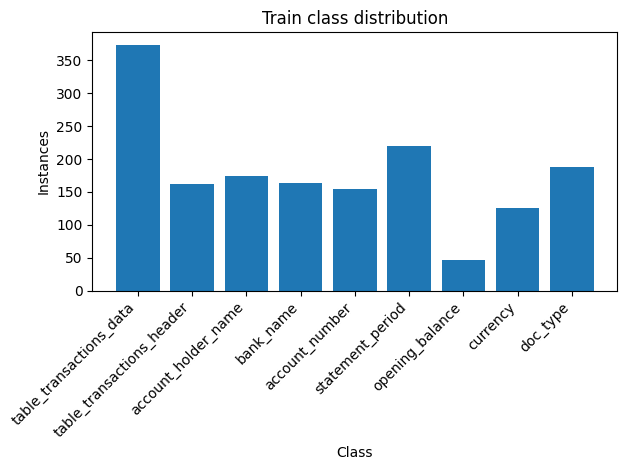

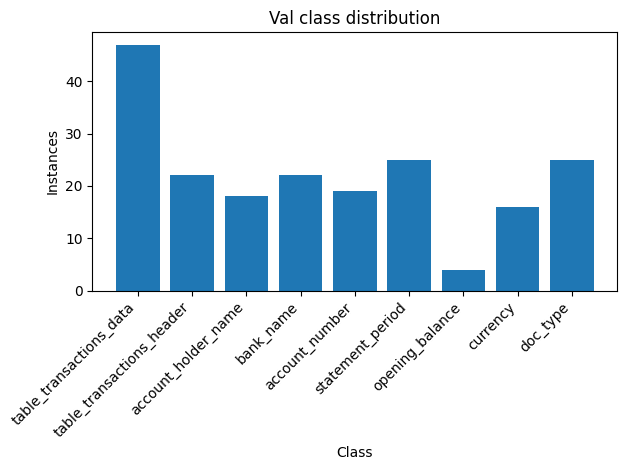

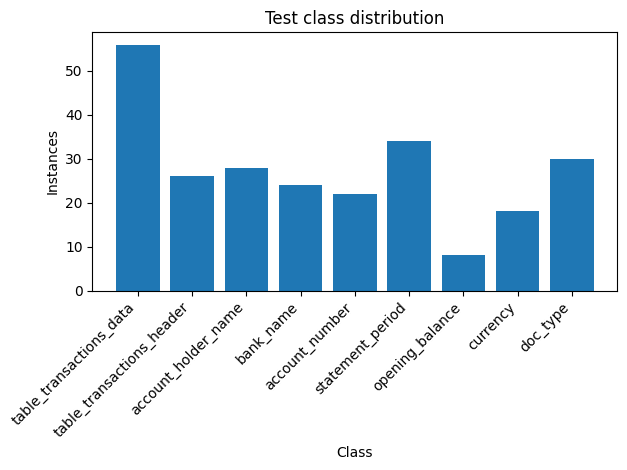


**What the plot shows**: dominant vs underrepresented classes.
**Why it matters**: Imbalance can reduce recall for rare classes.
**Action**: Use augmentation or collect more for rare classes.



In [4]:
# Class distribution plots
def read_labels(lbl_dir: Path):
    counts = Counter()
    for p in lbl_dir.rglob("*.txt"):
        for ln in open(p):
            parts = ln.strip().split()
            if len(parts) == 5 and parts[0].isdigit():
                cid = int(parts[0])
                counts[cid] += 1
    return counts

def plot_counts(title, counts, class_names):
    if not counts:
        print(f"[info] No labels to plot for: {title}")
        return
    idxs = sorted(counts.keys())
    xs = [class_names[i] if i < len(class_names) else f'class_{i}' for i in idxs]
    ys = [counts[i] for i in idxs]
    if any(i >= len(class_names) for i in idxs):
        bad = [i for i in idxs if i >= len(class_names)]
        print(f"[warn] Found class ids not in dataset.yaml: {bad}")
    plt.figure()
    plt.bar(xs, ys)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Instances")
    plt.tight_layout()
    plt.show()

train_counts = read_labels(YOLO_ROOT / "labels" / "train")
val_counts   = read_labels(YOLO_ROOT / "labels" / "val")
test_counts  = read_labels(YOLO_ROOT / "labels" / "test")

plot_counts("Train class distribution", train_counts, CLASSES)
plot_counts("Val class distribution",   val_counts,   CLASSES)
plot_counts("Test class distribution",  test_counts,  CLASSES)

print("""
**What the plot shows**: dominant vs underrepresented classes.
**Why it matters**: Imbalance can reduce recall for rare classes.
**Action**: Use augmentation or collect more for rare classes.
""")

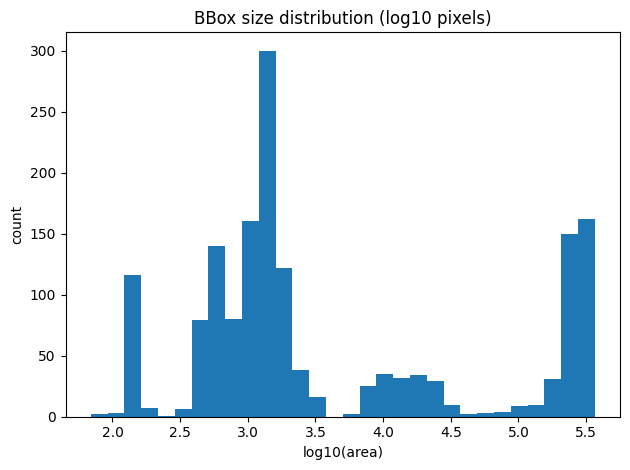

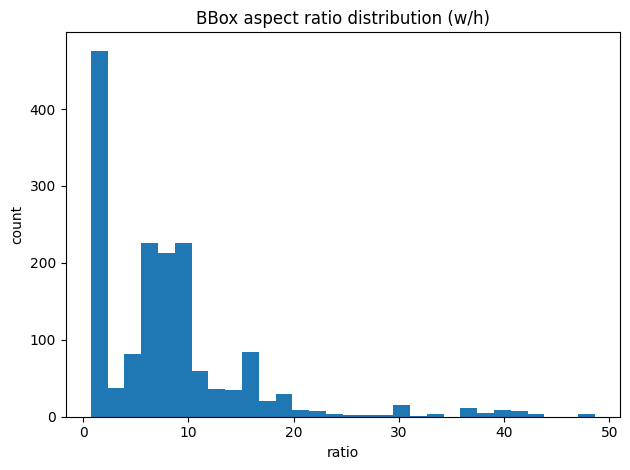


**What these show**: size buckets and width/height balance of boxes.
**Why it matters**: many tiny or extreme boxes suggest larger `imgsz` and tuned augmentations.
**Action**: If tiny text dominates, try imgsz=1024 and careful mosaic/scale.



In [5]:
# BBox sizes & aspect ratios
import cv2

IMG_DIR = YOLO_ROOT/"images/train"
LBL_DIR = YOLO_ROOT/"labels/train"
sizes, ratios = [], []

def yolo_record_iter(lbl_path):
    for ln in open(lbl_path):
        ps = ln.strip().split()
        if len(ps)==5:
            yield map(float, ps)  # class cx cy w h

for lbl_path in LBL_DIR.glob("*.txt"):
    # match image
    stem = lbl_path.stem
    img_path = None
    for ext in [".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"]:
        cand = IMG_DIR / f"{stem}{ext}"
        if cand.exists():
            img_path = cand
            break
    if not img_path: 
        continue
    im = cv2.imread(str(img_path))
    if im is None:
        continue
    H, W = im.shape[:2]
    for rec in yolo_record_iter(lbl_path):
        _, cx, cy, w, h = rec
        ww = w*W; hh = h*H
        sizes.append(ww*hh)
        ratios.append(ww/max(hh,1e-9))

plt.figure()
plt.hist(np.log10(np.array(sizes)+1), bins=30)
plt.title("BBox size distribution (log10 pixels)")
plt.xlabel("log10(area)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(ratios, bins=30)
plt.title("BBox aspect ratio distribution (w/h)")
plt.xlabel("ratio")
plt.ylabel("count")
plt.tight_layout()
plt.show()

print("""
**What these show**: size buckets and width/height balance of boxes.
**Why it matters**: many tiny or extreme boxes suggest larger `imgsz` and tuned augmentations.
**Action**: If tiny text dominates, try imgsz=1024 and careful mosaic/scale.
""")

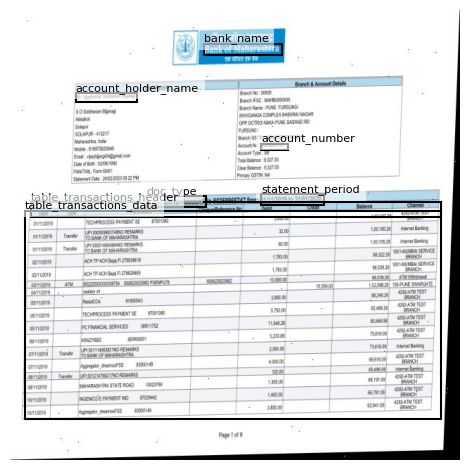

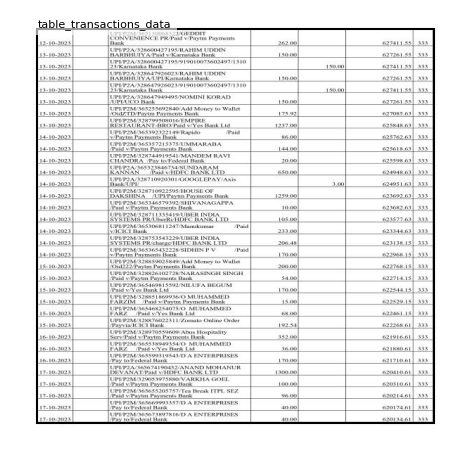

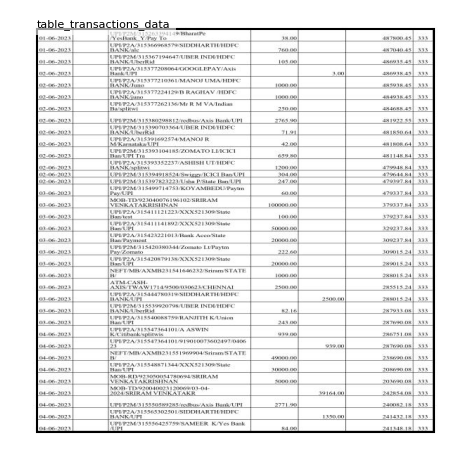

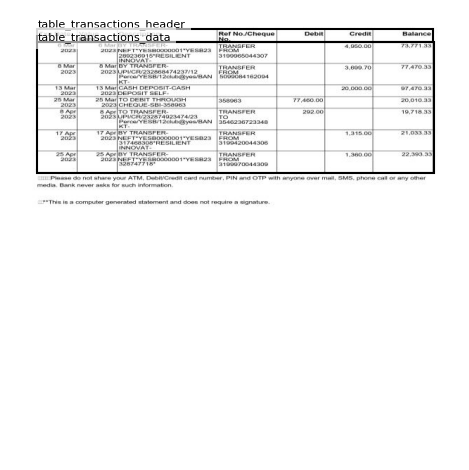

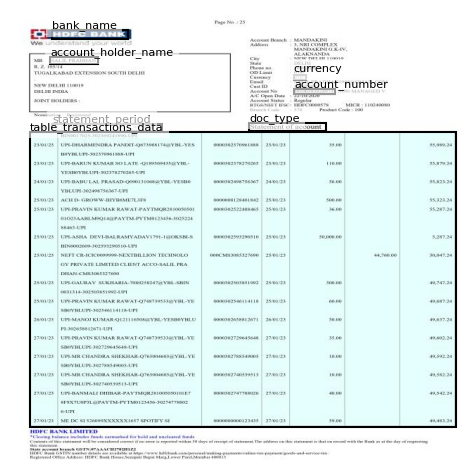

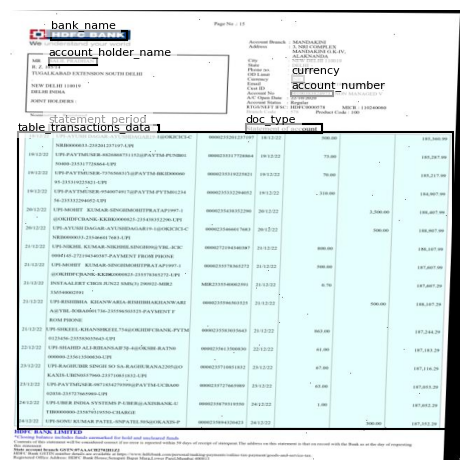


**What the grid shows**: quick QC of boxes & labels.
**Why it matters**: spotting mislabels early saves training cycles.
**Action**: fix any obvious bad labels before long runs.



In [6]:
# Labeled sample grid
import random
import matplotlib.patches as patches

def yolo_to_xyxy(cx, cy, w, h, W, H):
    x1 = (cx - w/2)*W; y1 = (cy - h/2)*H
    x2 = (cx + w/2)*W; y2 = (cy + h/2)*H
    return x1, y1, x2, y2

all_imgs = list((YOLO_ROOT/'images/train').glob('*.*'))
samples = random.sample(all_imgs, k=min(6, len(all_imgs))) if all_imgs else []

for img_path in samples:
    stem = img_path.stem
    lbl_path = YOLO_ROOT/'labels/train'/f"{stem}.txt"
    im_bgr = cv2.imread(str(img_path))
    if im_bgr is None:
        continue
    im = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    H, W = im.shape[:2]
    fig, ax = plt.subplots()
    ax.imshow(im)
    if lbl_path.exists():
        for ln in open(lbl_path):
            ps = ln.strip().split()
            if len(ps)==5:
                cid, cx, cy, w, h = map(float, ps)
                x1,y1,x2,y2 = yolo_to_xyxy(cx, cy, w, h, W, H)
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=1.5)
                ax.add_patch(rect)
                try:
                    name = CLASSES[int(cid)]
                except Exception:
                    name = f"class_{int(cid)}"
                ax.text(x1, max(0,y1-3), name, fontsize=8, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

print("""
**What the grid shows**: quick QC of boxes & labels.
**Why it matters**: spotting mislabels early saves training cycles.
**Action**: fix any obvious bad labels before long runs.
""")

## 4) Preprocessing
Use this to drop rare classes or merge labels before training.

In [7]:
# Convert uploaded PDFs to images
try:
    import fitz  # PyMuPDF
except Exception:
    fitz = None
    warnings.warn("PyMuPDF not installed; PDF->image step will be skipped.")

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def pdf_to_images(pdf_path: Path, out_dir: Path, dpi: int = 200):
    """
    Render a PDF to PNGs at ~dpi; returns list[Path].
    Safe for OCR (do NOT overwrite your detector images).
    """
    if fitz is None:
        warnings.warn("pdf_to_images skipped: PyMuPDF not available.")
        return []
    out_dir.mkdir(parents=True, exist_ok=True)
    doc = fitz.open(pdf_path)
    out_files = []
    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)
    for i, page in enumerate(doc):
        pix = page.get_pixmap(matrix=mat, alpha=False)
        out_path = out_dir / f"{pdf_path.stem}_p{i+1:03d}.png"
        pix.save(str(out_path))
        out_files.append(out_path)
    return out_files  

# Cleaning pipeline for OCR Copies
def auto_deskew_bgr(img_bgr, max_angle: float = 10.0):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thr  = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thr > 0))  
    if coords.size == 0:
        return img_bgr
    rect = cv2.minAreaRect(coords.astype(np.float32))
    angle = rect[-1]
    # OpenCV returns angle in [-90, 0)
    if angle < -45:
        angle = 90 + angle
    if abs(angle) > max_angle:
        return img_bgr
    (h, w) = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def trim_border(img_bgr, pad: int = 4):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    thr  = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ys, xs = np.where(thr < 250)
    if len(xs) == 0 or len(ys) == 0:
        return img_bgr
    x1, x2 = max(xs.min() - pad, 0), min(xs.max() + pad, img_bgr.shape[1] - 1)
    y1, y2 = max(ys.min() - pad, 0), min(ys.max() + pad, img_bgr.shape[0] - 1)
    return img_bgr[y1:y2 + 1, x1:x2 + 1]

def light_denoise(img_bgr):
    return cv2.bilateralFilter(img_bgr, d=5, sigmaColor=30, sigmaSpace=30)

def clean_page(src_img_path: Path, dst_img_path: Path) -> bool:
    im = cv2.imread(str(src_img_path))
    if im is None:
        return False
    im = auto_deskew_bgr(im)
    im = trim_border(im)
    im = light_denoise(im)
    dst_img_path.parent.mkdir(parents=True, exist_ok=True)
    return cv2.imwrite(str(dst_img_path), im)

#  cleaning for OCR copies (keeps RAW for detection) 
for split in ["train", "val"]:
    src_dir = RAW_IMG_DIR / split         # raw images that match your labels (do not alter)
    dst_dir = PROC_IMG / split            # cleaned copies for OCR only
    dst_dir.mkdir(parents=True, exist_ok=True)
    imgs = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff", "*.webp"):
        imgs += list(src_dir.rglob(ext))
    print(f"[{split}] found {len(imgs)} raw pages")
    for p in tqdm(imgs, desc=f"clean:{split}"):
        out = dst_dir / p.name            # same filename, different folder
        if not out.exists():
            _ = clean_page(p, out)

#  Tesseract OCR on cleaned copies 
import pytesseract, shutil

# Adjust path if needed
pytesseract.pytesseract.tesseract_cmd = shutil.which("tesseract") or "/opt/homebrew/bin/tesseract"
print("which tesseract:", shutil.which("tesseract"))
try:
    print("Tesseract:", pytesseract.get_tesseract_version())
except Exception as e:
    warnings.warn(f"Tesseract not runnable: {e}")

def _prep_for_ocr(bgr):
    h, w = bgr.shape[:2]
    scale = 1.5 if max(h, w) < 2000 else 1.2
    bgr = cv2.resize(bgr, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 5, 30, 30)
    thr  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 31, 15)
    return thr

def ocr_words(image_path: Path):
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"[ocr] could not read image: {image_path}")
        return []
    proc = _prep_for_ocr(img)
    data = pytesseract.image_to_data(proc, output_type=pytesseract.Output.DICT,
                                     config="--oem 1 --psm 6")
    out = []
    n = len(data.get("text", []))
    for i in range(n):
        txt = (data["text"][i] or "").strip()
        if not txt:
            continue
        x, y = int(data["left"][i]), int(data["top"][i])
        w, h = int(data["width"][i]), int(data["height"][i])
        try:
            conf_raw = float(data.get("conf", [0] * n)[i])
            conf = 0.0 if conf_raw < 0 else min(conf_raw / 100.0, 1.0)
        except Exception:
            conf = 0.0
        out.append({"text": txt, "bbox": [x, y, x + w, y + h], "score": conf})
    return out

def list_imgs(root: Path):
    imgs = []
    for e in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff","*.webp",
              "*.PNG","*.JPG","*.JPEG","*.BMP","*.TIF","*.TIFF","*.WEBP"):
        imgs += list(root.rglob(e))
    return imgs

summary = {"train": {"ok": 0, "fail": 0}, "val": {"ok": 0, "fail": 0}}

for split in ["train", "val"]:
    src = PROC_IMG / split
    dst = PROC_OCR / split
    dst.mkdir(parents=True, exist_ok=True)
    imgs = list_imgs(src)
    print(f"[{split}] {len(imgs)} cleaned pages (for OCR)")
    for p in tqdm(imgs, desc=f"ocr:{split}"):
        outj = dst / (p.stem + ".json")
        if outj.exists():
            summary[split]["ok"] += 1
            continue
        try:
            ws = ocr_words(p)
            im = cv2.imread(str(p))
            h, w = (im.shape[:2] if im is not None else (None, None))
            payload = {"image_path": str(p), "width": w, "height": h, "words": ws}
            outj.write_text(json.dumps(payload, ensure_ascii=False, indent=2))
            summary[split]["ok"] += 1
        except Exception as e:
            print(f"[OCR-ERR] {p.name}: {e}")
            summary[split]["fail"] += 1

print("OCR summary:", summary)

# Sanitize OCR JSONs (filter low-conf noise) 
def clean_words(words, min_conf=0.60, min_wh=6):
    out = []
    if not isinstance(words, list):
        return out
    for w in words:
        if not isinstance(w, dict):
            continue
        txt = (w.get("text") or "").strip()
        if not txt:
            continue
        try:
            conf = float(w.get("score", 0.0) or 0.0)
        except Exception:
            conf = 0.0
        if conf < min_conf:
            continue
        bbox = w.get("bbox")
        if not (isinstance(bbox, (list, tuple)) and len(bbox) == 4):
            continue
        try:
            x1, y1, x2, y2 = map(int, bbox)
        except Exception:
            continue
        if (x2 - x1) < min_wh or (y2 - y1) < min_wh:
            continue
        out.append({"text": txt, "bbox": [x1, y1, x2, y2], "score": conf})
    return out

def sanitize_split(split_dir: Path) -> tuple[int, int, int]:
    updated = skipped = bad = 0
    for jf in split_dir.glob("*.json"):
        try:
            payload = json.loads(jf.read_text())
            words = payload.get("words") or []
            payload["words"] = clean_words(words, min_conf=0.60)
            jf.write_text(json.dumps(payload, ensure_ascii=False, indent=2))
            updated += 1
        except Exception as e:
            print(f"[sanitize ERR] {jf.name}: {e}")
            skipped += 1
            try:
                w = json.loads(jf.read_text()).get("words")
                if not isinstance(w, list):
                    bad += 1
            except Exception:
                bad += 1
    return updated, skipped, bad

for split in ["train", "val"]:
    sdir = PROC_OCR / split
    sdir.mkdir(parents=True, exist_ok=True)
    upd, skp, bad = sanitize_split(sdir)
    print(f"[{split}] sanitized={upd}, skipped={skp}, non-list-words~={bad}")


[train] found 380 raw pages


clean:train: 100%|██████████| 380/380 [00:00<00:00, 98439.60it/s]


[val] found 47 raw pages


clean:val: 100%|██████████| 47/47 [00:00<00:00, 29191.81it/s]

which tesseract: None


Tesseract: 5.5.1
[train] 381 cleaned pages (for OCR)


ocr:train: 100%|██████████| 381/381 [00:00<00:00, 127689.16it/s]


[val] 47 cleaned pages (for OCR)


ocr:val: 100%|██████████| 47/47 [00:00<00:00, 53846.57it/s]

OCR summary: {'train': {'ok': 381, 'fail': 0}, 'val': {'ok': 47, 'fail': 0}}


[train] sanitized=381, skipped=0, non-list-words~=0
[val] sanitized=47, skipped=0, non-list-words~=0


## 5) Train & Finetune YOLO
Trains a detector on the Roboflow dataset to localize statement regions (tables, names, balances, etc.).

In [8]:
# Initialize model
from ultralytics import YOLO
model = YOLO("yolov8s.pt")  


In [9]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")
print(model.model)  # This prints a summary of the module tree


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [10]:
%pip install torchviz graphviz


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from pathlib import Path

DATASET_YAML = Path("/Volumes/Peach/uwezo_capstone_project/uwezo_project/yolo/dataset.yaml")

# Auto-select device
if torch.cuda.is_available():
    YOLO_DEVICE = 0
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    YOLO_DEVICE = "mps"
else:
    YOLO_DEVICE = "cpu"

print("Using device:", YOLO_DEVICE)

YOLO_EPOCHS = 50
YOLO_IMGSZ  = 640

# Print model info 
model.info()

# Train model
results = model.train(
    data=str(DATASET_YAML),
    imgsz=YOLO_IMGSZ,
    epochs=YOLO_EPOCHS,
    device=YOLO_DEVICE,
    rect=True,
    batch=4,
)



Using device: mps
YOLOv8s summary: 129 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs
New https://pypi.org/project/ultralytics/8.3.220 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.218 🚀 Python-3.11.9 torch-2.9.0 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Volumes/Peach/uwezo_capstone_project/uwezo_project/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode

## 6) Build Bio Tag Training 

In [ ]:
# paths
IMG_TRAIN   = Path(PROC_IMG) / "train"
IMG_VAL     = Path(PROC_IMG) / "val"
OCR_TRAIN   = Path(PROC_OCR) / "train"
OCR_VAL     = Path(PROC_OCR) / "val"
LBL_TRAIN   = Path(YOLO_ROOT) / "labels" / "train"
LBL_VAL     = Path(YOLO_ROOT) / "labels" / "val"

CLASSES = [
    "table_transactions_data","table_transactions_header","account_holder_name",
    "bank_name","account_number","statement_period","opening_balance",
    "currency","doc_type"
]
BIO_LABELS = ["O"] + [f"B-{c}" for c in CLASSES] + [f"I-{c}" for c in CLASSES]
id2label = {i:l for i,l in enumerate(BIO_LABELS)}
label2id = {l:i for i,l in id2label.items()}

def load_yolo(lbl_path, W, H):
    out=[]
    if not lbl_path.exists(): return out
    for ln in lbl_path.read_text().strip().splitlines():
        c,xc,yc,w,h = ln.split()
        c = int(c); xc,yc,w,h = map(float,(xc,yc,w,h))
        x1 = max(int((xc-w/2)*W),0); y1 = max(int((yc-h/2)*H),0)
        x2 = min(int((xc+w/2)*W),W-1); y2 = min(int((yc+h/2)*H),H-1)
        out.append({"cid":c,"name":CLASSES[c],"bbox":[x1,y1,x2,y2]})
    return out

def center_in(box, x, y):
    x1,y1,x2,y2 = box
    return x1 <= x <= x2 and y1 <= y <= y2

def to_bio(words, fields):
    # words: [{"text","bbox":[x1,y1,x2,y2]}], fields: [{"name","bbox":[...]}]
    tags = ["O"] * len(words)
    for i,w in enumerate(words):
        x1,y1,x2,y2 = w["bbox"]
        cx,cy = (x1+x2)//2, (y1+y2)//2
        hit = None
        for f in fields:
            if center_in(f["bbox"], cx, cy):
                hit = f["name"]; break
        if hit:
            # very simple heuristic: first token B-, subsequent I-
            # (we don’t have tokenization yet, so apply when consecutive words are in same field)
            prev = tags[i-1] if i>0 else "O"
            prefix = "I-" if prev.endswith(hit) else "B-"
            tags[i] = f"{prefix}{hit}"
    return tags

def page_examples(split):
    img_dir = IMG_TRAIN if split=="train" else IMG_VAL
    ocr_dir = OCR_TRAIN if split=="train" else OCR_VAL
    lbl_dir = LBL_TRAIN if split=="train" else LBL_VAL

    items=[]
    for jp in sorted(ocr_dir.glob("*.json")):
        data = json.loads(jp.read_text())
        W,H = data["width"], data["height"]
        words = data["words"] or []
        # normalize empty
        words = [w for w in words if w.get("text","").strip()]
        img_path = Path(data["image_path"])
        # labels
        lbl = lbl_dir / (img_path.stem + ".txt")
        fields = load_yolo(lbl, W, H)
        tags = to_bio(words, fields)
        assert len(tags)==len(words)
        # LayoutLMv3 expects 0-1000 scaled boxes
        boxes_1000 = []
        for w in words:
            x1,y1,x2,y2 = w["bbox"]
            boxes_1000.append([
                int(1000*x1/W), int(1000*y1/H), int(1000*x2/W), int(1000*y2/H)
            ])
        items.append({
            "image_path": str(img_path),
            "words": [w["text"] for w in words],
            "boxes": boxes_1000,
            "labels": [label2id[t] for t in tags]
        })
    return items

train_items = page_examples("train")
val_items   = page_examples("val")
print(f"Train pages: {len(train_items)}, Val pages: {len(val_items)}")


## 7) Encode with LayoutLMV3 Processor


In [ ]:
processor = LayoutLMv3Processor.from_pretrained(
    "microsoft/layoutlmv3-base",
    apply_ocr=False  # we already provide words+boxes
)

def encode_batch(batch):
    # processor needs PIL images
    from PIL import Image
    images = [Image.open(p).convert("RGB") for p in batch["image_path"]]
    enc = processor(
        images=images,
        text=batch["words"],
        boxes=batch["boxes"],
        word_labels=batch["labels"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    return {k: v.numpy() for k,v in enc.items()}

ds = DatasetDict({
    "train": Dataset.from_list(train_items),
    "validation": Dataset.from_list(val_items)
})
encoded = ds.map(encode_batch, batched=True, remove_columns=ds["train"].column_names)
encoded




## 8) Training LayoutMv3 (token Classification)

In [ ]:
# PREP: make HF downloads + metrics robust

import numpy as np
import evaluate
from pathlib import Path
from transformers import (
    AutoProcessor,
    LayoutLMv3ForTokenClassification,
    Trainer,
    TrainingArguments,
)# optional: quieter logs

# 1) Processor & model
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
num_labels = len(BIO_LABELS)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# 2) Metrics (seqeval)
metric = evaluate.load("seqeval")

def _align_predictions(predictions, labels, id2label):
    """
    Align token-level predictions and references by dropping positions where label == -100.
    """
    preds = np.argmax(predictions, axis=-1)
    true_preds, true_labels = [], []
    for p_row, l_row in zip(preds, labels):
        tp, tl = [], []
        for p, l in zip(p_row, l_row):
            if l == -100:                 # ignore special/padded tokens
                continue
            tp.append(id2label[int(p)])
            tl.append(id2label[int(l)])
        true_preds.append(tp)
        true_labels.append(tl)
    return true_preds, true_labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds, refs = _align_predictions(predictions, labels, id2label)
    res = metric.compute(predictions=preds, references=refs)
    # expose standard names Trainer can sort on
    return {
        "precision": res["overall_precision"],
        "recall":    res["overall_recall"],
        "f1":        res["overall_f1"],
        "accuracy":  res["overall_accuracy"],
    }

# 3) Training args + Trainer
args = TrainingArguments(
    output_dir=str(Path(PROJECT_ROOT) / "models" / "layoutlmv3_runs"),
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    bf16=False, fp16=False,    
    load_best_model_at_end=True,
    metric_for_best_model="f1",      
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()


## 9) Inference

In [ ]:
def predict_fields(img_path: Path, ocr_json: Path):
    data = json.loads(ocr_json.read_text())
    W,H = data["width"], data["height"]
    words = [w for w in data["words"] if (w.get("text","").strip())]
    boxes = [[int(1000*w["bbox"][0]/W), int(1000*w["bbox"][1]/H),
              int(1000*w["bbox"][2]/W), int(1000*w["bbox"][3]/H)] for w in words]

    enc = processor(
        images=Image.open(img_path).convert("RGB"),
        text=[w["text"] for w in words],
        boxes=boxes,
        return_tensors="pt",
        truncation=True, padding="max_length", max_length=512
    )
    with torch.no_grad():
        logits = model(**{k:v for k,v in enc.items() if k in ["input_ids","bbox","attention_mask","pixel_values"]}).logits
    pred = logits.argmax(-1)[0].tolist()
    mask = enc["attention_mask"][0].tolist()

    fields = {c:[] for c in CLASSES}
    cur_field = None
    for t, wtxt, m in zip(pred, [w["text"] for w in words], mask):
        if not m: continue
        tag = id2label.get(t, "O")
        if tag.startswith("B-"):
            cur_field = tag[2:]
            fields[cur_field].append(wtxt)
        elif tag.startswith("I-") and cur_field == tag[2:]:
            fields[cur_field].append(wtxt)
        else:
            cur_field = None
    return {k: " ".join(v).strip() for k,v in fields.items()}

# example
ex_img = (PROC_IMG/"val").rglob("*.jpg").__next__()
ex_json = PROC_OCR/"val"/(ex_img.stem + ".json")
print(predict_fields(ex_img, ex_json))
